<a href="https://colab.research.google.com/github/biozid-0208/daily-random-programming-commit/blob/main/FinalProject-final-version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
# Importing the supporting
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import networkx as nx
from numpy.random import default_rng
import pandas as pd
import random
import copy

In [56]:
#---------------- function generate_random_color ----------------
# This function receives an integer, and generates that much random colors.
def generate_random_color(number_of_colors):

    list_of_colors = []
    for i in range(number_of_colors):
        r = lambda: random.randint(0,255)
        color = '#%02X%02X%02X' % (r(),r(),r())
        while (color == '#FF0000') or (color in list_of_colors):
            color = '#%02X%02X%02X' % (r(), r(), r())
        list_of_colors.append(color)
    return list_of_colors

colors =  generate_random_color(75)   

In [57]:
def netwrok_generator(state, ser, req):
    if state == 0:
        # define the network
        conn = np.random.randint(ser, size=(ser, ser))
        conn = np.tril(conn) + np.tril(conn, -1).T
        np.fill_diagonal(conn, 0)

        #define all requests
        rng = default_rng()
        tasks = rng.choice(ser, size=(req, 2), replace=True)
    else:
        conn = np.asarray([1])
        tasks = np.asarray([1])
    return conn, tasks

In [58]:
def routing_proc(G, requests):
  paths = []
  path_dictionary = {}
  counter = 0
  
  for req in requests:
    path = nx.shortest_path(G, source=req[0], target=req[1], weight='weight')
    paths.append(path)

  for path in paths:
    result = []
    counter += 1
    for elm in range(0, len(path)-1):
      result.append((path[elm], path[elm+1]))
      key = 't'+ str(counter)
      path_dictionary[key] = result
  return path_dictionary




In [59]:
def detect_overlap(a, b):
  for i in a:
    for j in b:
      if set(i) == set(j):
        return 1
  return 0

In [60]:
def collision_manager(path_dictionary):
  arr = []
  for k1 in path_dictionary.keys() :
    tem = []
    for k2 in path_dictionary.keys():
      if k1 == k2:
        result = 0
      else:
        result = detect_overlap(path_dictionary[k1], path_dictionary[k2])
      tem.append(result)
    arr.append(tem)
  return np.array(arr)

In [61]:
#---------------- function greedy coloring  ----------------
def greedy_color_graph(transmission_matrix):
  color_codes = []
  T1 = nx.from_numpy_matrix(transmission_matrix)
  g2 = nx.coloring.greedy_color(T1, strategy="largest_first")
  print('\033[1;32m' + "Chromatic number is: " + str(len(set(g2.values()))) + '\033[1;32m')
  for k in g2.keys():
    T1.nodes[k]['color'] = colors[g2[k]]
  colors_nodes = [data['color'] for v, data in T1.nodes(data=True)]
  pos = nx.circular_layout(T1) # Set position layout
  nx.draw(T1, pos, node_color=colors_nodes, node_size=1000, with_labels=True, font_weight='bold',    font_size=15)


In [62]:
def maximum_degree(graph_):
    degrees = [deg for name,deg in graph_.degree]
    return max(degrees)



#---------------- function assign_color ----------------
# This function receives a graph and a list of colors as input, and assigns a valid color in the list to the
# nodes of the graph and returns the result graph.
def assign_color(graph_, colors):

    for node in graph_.nodes:
        graph_.nodes[node]['color'] = '#FF0000'
    for node in graph_.nodes:
        adjacent_colors = []
        for adj_node in graph_.adj[node].keys():
            adjacent_colors.append(graph_.nodes[adj_node]['color'])
        while (graph_.nodes[node]['color'] == '#FF0000') or (graph_.nodes[node]['color'] in adjacent_colors):
            graph_.nodes[node]['color'] = random.choice(colors)
    return graph_

#---------------- function initial_state_generator ----------------
# This function receives a graph as input, and returns a graph in a random-color state, so that
# we can run Simulated Annealing algorithm on that graph. It also returns the list of colors to be used in HC.
def initial_state_generator(graph):

    max_deg = maximum_degree(graph)
    color_list = generate_random_color(max_deg+1)
    graph = assign_color(graph, color_list)
    return graph, color_list

#---------------- function loss_function ----------------
# This function calculates the loss-function for each state
# Loss value is defined to be the number of colors used for coloring a graph
def loss_function(graph_):

    used_colors = []
    for node in graph_.nodes():
        if graph_.nodes[node]['color'] not in used_colors:
            used_colors.append(graph_.nodes[node]['color'])
    return len(used_colors)


#---------------- function choose_next_state ----------------
# This function receives a dictionary of nodes (zzz) and chooses one node randomly among them all.
def choose_next_state(graph_, nodes_dict):

    (node, color) = random.choice(list(nodes_dict.keys()))

    graph_.nodes[node]['color'] = color
    graph_ = hill_climbing(graph_, color_list)
    return graph_



#---------------- function hill climbing approach ----------------
def hill_climbing(graph, colors):

    candidate_colored_nodes = {}
    current_loss = copy.deepcopy(loss_function(graph))

    for node in graph.nodes():
        node_initial_color = copy.deepcopy(graph.nodes[node]['color'])
        adjacent_colors = []
        for adj_node in graph.adj[node]:
            adjacent_colors.append(graph.nodes[adj_node]['color'])

        for color in colors: # check all the colors and compare with each other
            if color not in set(adjacent_colors):
                graph.nodes[node]['color'] = color
                if (loss_function(graph) <= current_loss):
                    candidate_colored_nodes[(node, color)] = loss_function(graph)
        graph.nodes[node]['color'] = node_initial_color

    if bool(candidate_colored_nodes):
        return graph
    else:
        graph = choose_next_state(graph, candidate_colored_nodes)
        return graph


In [63]:
def hill_climbing_graph_coloring(connection, request):
  T3 = nx.from_numpy_matrix(collision_manager(routing_proc(create_graph(connection, False), request)))
  G, color_list = initial_state_generator(T3)
  restart_times = 5
  best_found = copy.deepcopy(G)

  for i in range(restart_times):
      current_graph = copy.deepcopy(G)
      current_graph = hill_climbing(current_graph, color_list)
      current_loss = copy.deepcopy(loss_function(current_graph))
      # print('\033[1;36m' + "Iteration: " + str(i) + "    loss: " + str(current_loss) + '\033[0m')
      # print_graph(current_graph)
      if (loss_function(current_graph) < loss_function(best_found)):
          best_found = copy.deepcopy(current_graph)

  #---------------- printing results ----------------
  node_colors = []
  for node in best_found.nodes():
      node_colors.append(best_found.nodes[node]['color'])
  print('\033[1;32m' + "Chromatic number is: " + str(len(set(node_colors))) + '\033[1;32m')

  pos = nx.circular_layout(best_found) # Set position layout
  nx.draw(best_found, pos, node_color=node_colors, node_size=1000, with_labels=True, font_weight='bold',    font_size=15)
  plt.axis('off') # To prevent showing X-Y axes
  plt.show() # Displays the graph

In [64]:
def create_graph(connection, figure=True):
  G2 = nx.from_numpy_matrix(connection)
  if figure:
    layout = nx.spring_layout(G2)
    nx.draw(G2, layout, node_size=500, with_labels=True)
    labels = nx.get_edge_attributes(G2,'weight')
    # nx.draw_networkx_edge_labels(G2,pos=layout,edge_labels=labels)
    plt.show()
  return G2

In [65]:
def print_transmission_matrix(adj_mtx):
  fig, ax = plt.subplots()
  ax.imshow(adj_mtx, cmap="Blues")
  ax.set_xticks(np.arange(len(adj_mtx[0])))
  ax.set_yticks(np.arange(len(adj_mtx[0])))
  ax.set_xticklabels(range(0,len(adj_mtx[0])))
  ax.set_yticklabels(range(0,len(adj_mtx[0])))

  for i in range(len(adj_mtx[0])):
      for j in range(len(adj_mtx[0])):
          text_color = 'black' if adj_mtx[i, j] == 0 else 'white'
          text = ax.text(j, i, adj_mtx[i, j], ha="center", va="center", color=text_color)

  ax.set_title("Collision matrix", fontsize=12)
  plt.show()

{'t1': [(7, 8)], 't2': [(7, 8)], 't3': [(2, 7), (7, 3)], 't4': [(1, 7), (7, 3), (3, 5)], 't5': [(4, 6)], 't6': [(5, 6), (6, 4)], 't7': [(7, 3)], 't8': [(8, 7), (7, 3)], 't10': [(0, 6)], 't11': [(2, 0), (0, 6)], 't12': [(5, 3)]}


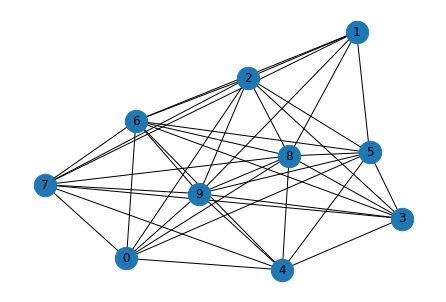

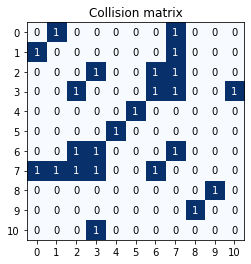

In [66]:
num_server = 10
num_request = 12
connection, request = netwrok_generator(0, num_server, num_request)
print(routing_proc(create_graph(connection, False), request))
print_transmission_matrix(collision_manager(routing_proc(create_graph(connection, True), request)))

Chromatic number is: 4


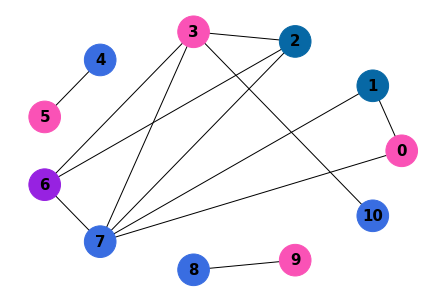

In [67]:
greedy_color_graph(collision_manager(routing_proc(create_graph(connection, False), request)))

Chromatic number is: 6


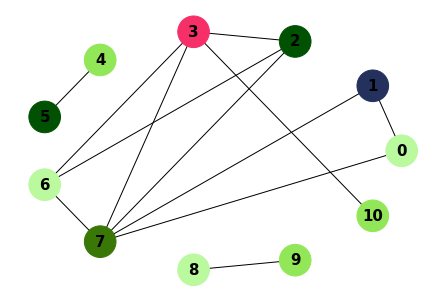

In [68]:
hill_climbing_graph_coloring(connection, request)